In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout

2024-09-23 19:48:04.593642: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-23 19:48:04.594216: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-23 19:48:04.596756: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-23 19:48:04.605361: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-23 19:48:04.618549: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [3]:
rndr_df = pd.read_csv('RNDR_historical_data.csv')

In [4]:
# Function to preprocess the data
def preprocess_data(data, sequence_length=50):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(scaled_data[i-sequence_length:i])
        y.append(scaled_data[i])
    
    X, y = np.array(X), np.array(y)
    return X, y, scaler


In [5]:
# Function to create and compile LSTM or GRU models
def create_model(model_type, input_shape):
    model = Sequential()

    if model_type == 'LSTM':
        model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
        model.add(Dropout(0.2))
        model.add(LSTM(units=50, return_sequences=False))
    elif model_type == 'GRU':
        model.add(GRU(units=50, return_sequences=True, input_shape=input_shape))
        model.add(Dropout(0.2))
        model.add(GRU(units=50, return_sequences=False))
    
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Output layer for price prediction

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [6]:
# Function to train and test the model
def train_and_evaluate_model(data, model_type, sequence_length=50, epochs=10, batch_size=32):
    # Preprocessing the data
    X, y, scaler = preprocess_data(data, sequence_length=sequence_length)
    
    # Split into training and testing data
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Create model
    model = create_model(model_type, (X_train.shape[1], X_train.shape[2]))
    
    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Inverse transform the predicted values
    y_pred_scaled = scaler.inverse_transform(y_pred)
    y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Plot the results
    plt.plot(y_test_scaled, color='blue', label='Real Prices')
    plt.plot(y_pred_scaled, color='red', label=f'Predicted Prices ({model_type})')
    plt.title(f'{model_type} Model Predictions')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    return model


In [7]:
# Load your data
data = pd.read_csv('RNDR_historical_data.csv')['price'].values.reshape(-1, 1)

Epoch 1/10


/home/gustavomachado/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.1718
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0404
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0188
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0121
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0117
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0090
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0106
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0079
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0080
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0083
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  


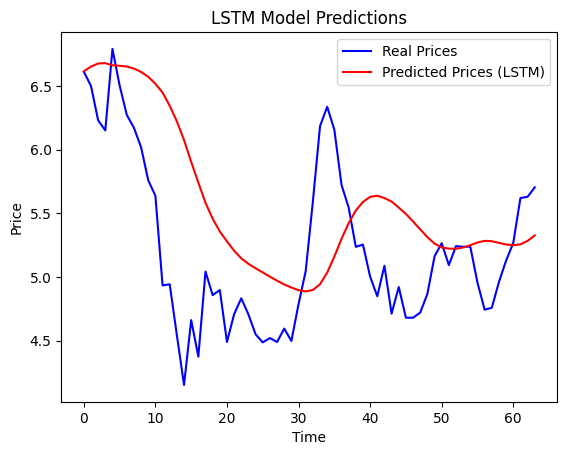

Epoch 1/10


/home/gustavomachado/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.2642
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0234
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0222
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0155
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0127
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0112
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0073
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0064
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0070
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0057
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


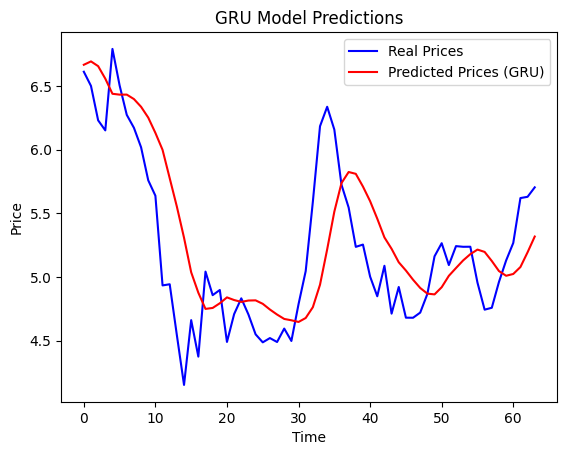

<Sequential name=sequential_1, built=True>

In [8]:

# Train and evaluate both LSTM and GRU models
train_and_evaluate_model(data, 'LSTM', sequence_length=50, epochs=10, batch_size=32)
train_and_evaluate_model(data, 'GRU', sequence_length=50, epochs=10, batch_size=32)
